## Prepare the ALOS-2 multiple aperture interferometry (MAI) result

The MAI result is processed by Cunren Liang (Peking University).

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut, attribute as attr
plt.rcParams.update({'font.size': 12})

dname = 'ALOS2_A184_20220905_20230220_MAI'
dname = 'ALOS2_D077_20220916_20230217_MAI'

proj_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ')
work_dir = os.path.join(proj_dir, 'CunrenLiang', dname)
os.chdir(work_dir)
print('Go to directory:', work_dir)

S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1

# input files
in_file = './mai/isce/azd.geo.float'
cor_file = './insar_cor/isce/cor.geo.float'
enu_file = './flight_direction/enu_isce/enu.geo'

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/CunrenLiang/ALOS2_D077_20220916_20230217_MAI


## Read [Crop & Mask]

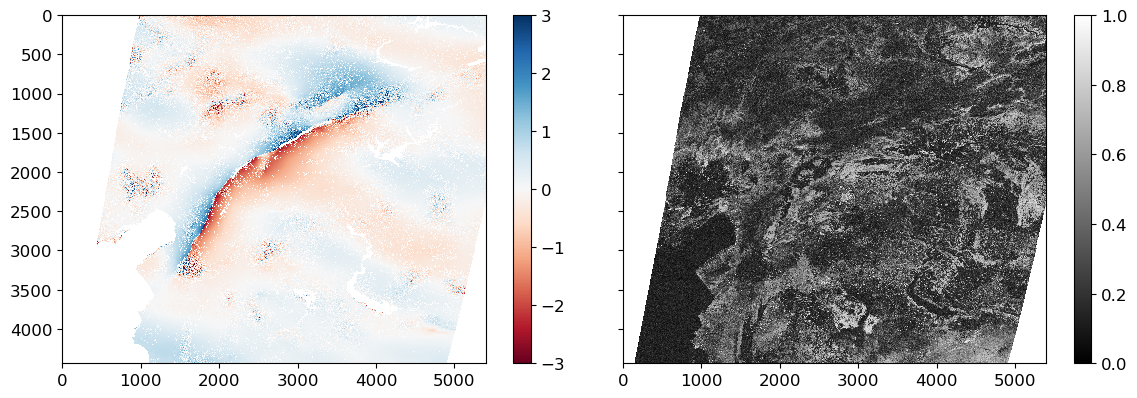

In [2]:
max_defo = 5; min_cor = 0.12

# calc box
atr = readfile.read_attribute(in_file)
coord = ut.coordinate(atr)
box = coord.box_geo2pixel(geo_box=(W, N, E, S))

# read
dis = readfile.read(in_file, box=box)[0]
# convert 0 to nan
dis[dis == 0] = np.nan
# spatial referencing to the global mean
dis -= np.nanmedian(dis)
# mask out pixels > max_defo
dis[np.abs(dis) > max_defo] = np.nan

# mask out low coherent pixels
cor = readfile.read(cor_file, box=box)[0]
cor[cor == 0] = np.nan
cor[cor > 1] = 1
dis[cor < min_cor] = np.nan

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 4], sharey=True)
im = axs[0].imshow(dis, vmin=-3, vmax=3, cmap='RdBu', interpolation='nearest');  fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(cor, vmin=0,  vmax=1, cmap='gray', interpolation='nearest');  fig.colorbar(im, ax=axs[1])
fig.tight_layout()
plt.show()

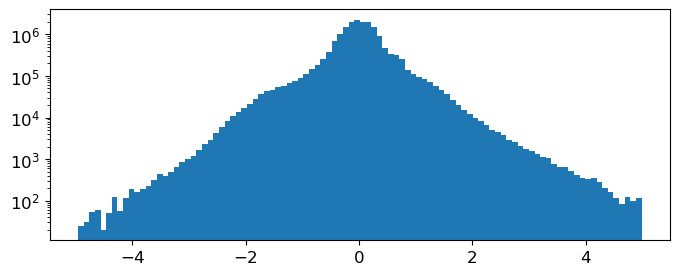

In [3]:
plt.figure(figsize=[8, 3])
plt.hist(dis.flatten(), bins=100, log=True)
plt.show()

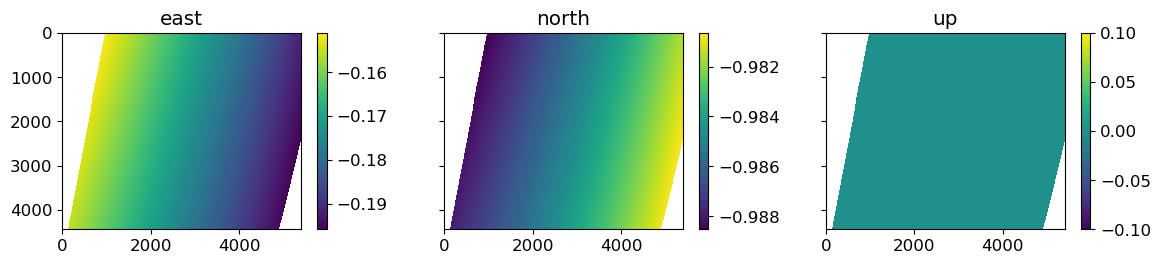

In [4]:
ve = readfile.read(enu_file, datasetName='band1', box=box)[0]
vn = readfile.read(enu_file, datasetName='band2', box=box)[0]
vu = readfile.read(enu_file, datasetName='band3', box=box)[0]
# mask out pixels with no-data-value
ve[ve == 0] = np.nan
vn[vn == 0] = np.nan
vu[vu == 1] = np.nan

# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12, 2.6], sharey=True)
for ax, vi, title in zip(axs, [ve, vn, vu], ['east', 'north', 'up']):
    im = ax.imshow(vi, interpolation='nearest')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

## Write 

In [5]:
## prepare metadata
atr = readfile.read_attribute(in_file)
# update metadata due to crop
atr = attr.update_attribute4subset(atr, box)

## write displacement file
out_file = './mai_msk.geo'
# metadata
atr['BANDS'] = '1'
atr['DATA_TYPE'] = 'float32'
writefile.write_isce_xml(atr, fname=out_file)
writefile.write_roipac_rsc(atr, out_file=out_file+'.rsc')
# binary
data = np.array(dis, dtype=np.float32)
print(f'write file: {out_file}')
data.tofile(out_file)

## write coherence file
out_file = './geo_filt.cor'
# metadata
writefile.write_isce_xml(atr, fname=out_file)
writefile.write_roipac_rsc(atr, out_file=out_file+'.rsc')
# binary
data = np.array(cor, dtype=np.float32)
print(f'write file: {out_file}')
data.tofile(out_file)

## write unit vector file
out_file = './enu.geo'
# metadata
atr['BANDS'] = '3'
atr['INTERLEAVE'] = 'BIL'
atr['DATA_TYPE'] = 'float32'
writefile.write_isce_xml(atr, fname=out_file)
writefile.write_roipac_rsc(atr, out_file=out_file+'.rsc')
# binary
data = np.hstack((ve, vn, vu), dtype=np.float32)
print(f'write file: {out_file}')
data.tofile(out_file)

update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 197/1073/5597/5513
update Y/X_FIRST
write file: ./mai_msk.geo.xml
write file: ./mai_msk.geo.vrt
write file: ./mai_msk.geo
write file: ./geo_filt.cor.xml
write file: ./geo_filt.cor.vrt
write file: ./geo_filt.cor
write file: ./enu.geo.xml
write file: ./enu.geo.vrt
write file: ./enu.geo
